# Page rank

## Imports

In [107]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import networkx as nx
import graphviz as gv
import random

from typing import List

## Network classes

In [2]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.outgoingLinks = []
        self.incomingLinks = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkFrom(self, other):
        """Adds a link from another page, ending at this page"""
        self.incomingLinks.append(other)
    
    def addLinkTo(self, other):
        """Adds a link to another page, starting from this page"""
        self.outgoingLinks.append(other)
        other.addLinkFrom(self)
        
    def addLinksTo(self, *args):
        """Adds a link to another page, starting from this page"""
        for page in args:
            self.addLinkTo(page)
        
    def outDegree(self):
        """Returns the amount of links this page has to other pages, i.e. its out-degree"""
        return len(self.outgoingLinks)
    
    def getName(self):
        return self.name
    
    def linksTo(self, other) -> bool:
        return other in self.outgoingLinks

In [3]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
        
        # Whether the dataframe is out of date
        self.old_df = True
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
        
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
        # Dataframe is out of date now
        self.old_df = True
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    def debugRanking(self):
        """
        Computes the sum of the rank of all pages in the network, which *should* return 1.
        """
        rankSum = 0
        for page in self:
            rankSum += page.rank
        print(rankSum)
        
    def testUnconnected(self):
        """
        Prints if there are unconnected pages (pages with no link to or from them) in the network.
        """
        for page in self:
            if (len(page.incomingLinks)==0) & (len(page.outgoingLinks)==0):
                print("Page {} is unconnected".format(page.getName()))
        print("All unreported pages are connected to at least one other node via an incoming/outgoing link.")
    
    # ----------------------------------------------------------
    # --------------------- VISUALIZATION ----------------------
    # ----------------------------------------------------------
    
    # ------------------- NODE-LINK DIAGRAMS ------------------- 
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.outgoingLinks:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.outgoingLinks) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self, names=False):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by rank
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.outgoingLinks:
                f.edge(str(page), str(other))

        return f
    
    # ----------------------- STATISTICS -----------------------
    def updateDf(self):
        """Update pandas DataFrame of this network."""
        
        # Prepare a dataframe
        df = pd.DataFrame(columns=['Name', 'Outdegree', 'Indegree'])
        
        df['Name'] = list(map(Page.getName, self.pages))
        df['Outdegree'] = list(map(Page.outDegree, self.pages))
        df.fillna(0, inplace=True)
        
        # Count indegree of every page
        for page in self:
            for link in page.outgoingLinks:
                df.at[link.id, 'Indegree'] += 1
        
        # Update dataframe
        self.df = df
        self.old_df = False
        
    def plot_outdegrees(self):
        """Plots a histogram of the outdegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Outdegree'], kde=False, rug=True)
        ax.set_xlabel("Outdegree (number of links to other pages)")
        ax.set_ylabel("Frequency")
        
    def plot_indegrees(self):
        """Plots a histogram of the indegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Indegree'], kde=False, rug=True)
        ax.set_xlabel("Indegree (number of links to this page from other pages)")
        ax.set_ylabel("Frequency")
        
    def describe(self):
        """Prints a table of summary statistics of this network."""
        if self.old_df:
            self.updateDf()
            
        return self.df.describe()
    
    def getDf(self):
        """Returns the dataframe of this network, updates it when needed."""
        if self.old_df:
            self.updateDf()
            
        return self.df
    
    def sinks(self):
        """Returns the sinks of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Outdegree'] == 0]
        
    def sources(self):
        """Returns the sources of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Indegree'] == 0]

### Example Wikipedia-YouTube-Twitter

In [4]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [5]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [6]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [7]:
yt.incomingLinks

[Wikipedia, Twitter]

In [8]:
yt.outgoingLinks

[Twitter]

### Example California Network

In [9]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [10]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [134]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rankCR(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None): # rankCR = rankCertainRestart
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        initRanks = PageRanker.calculateInitialRanking(network)
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRankCR(network, alpha)
        
        else:
            n = 0
            oldRanks = initRanks
            while True:
                n += 1
                newRanks = PageRanker.stepRankCR(network, alpha)
#                 print(newRanks)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
#             print(f'Iterations: {n}')
            return n
    
    @staticmethod
    def stepRankCR(network: Network, alpha: float):
        """
        Does one step of the random-restart ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            # Sum dot product of column and stationary distribution
            for other in network:
                if other.outDegree() > 0:
                    newRanks[page] += other.rank * page.q * (1 - alpha)
                else:
                    newRanks[page] += other.rank * page.q
                if other.linksTo(page):
                    newRanks[page] += other.rank * alpha / other.outDegree()

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def rank(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None):
        """
        Ranks a network via the PageRank algorithm.
        Runtime O(steps * #pages * max. incoming links for a page)
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        initRanks = PageRanker.calculateInitialRanking(network)
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRank(network, alpha)
            
        else:
            n = 0
            oldRanks = initRanks
            while True:
                n += 1
                newRanks = PageRanker.stepRank(network, alpha)
#                 print(newRanks)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
#             print(f'Iterations: {n}')
            return n

        rankSum = sum([page.rank for page in network])
        for page in network:
            page.rank = page.rank/rankSum

    @staticmethod
    def stepRank(network: Network, alpha: float):
        """
        Does one step of the normalized ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            for other in page.incomingLinks:
                newRanks[page] += other.rank / other.outDegree()
            newRanks[page] *= alpha
            newRanks[page] += (1-alpha) * page.q

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1.0 / network.size()
#             print("initial rank for " + str(network.size()) + " pages is " + str((1.0 / network.size())) )
            # When looking at the above print command for large networks, the sum doesn't necessarily add to 1 perfectly
            # anymore due to rounding errors
        
        return {page:1.0/network.size() for page in network}
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1.0 / network.size()


### Example Wikipedia-YouTube-Twitter Calculation

In [12]:
PageRanker.calculateInitialRanking(internet)

{YouTube: 0.3333333333333333,
 Wikipedia: 0.3333333333333333,
 Twitter: 0.3333333333333333}

#### Wikipedia-YouTube-Twitter with the Certain Restart Version

In [13]:
PageRanker.rankCR(internet)
internet.showRanking()
internet.debugRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666663
Twitter: 0.41666666666666663
0.9999999999999999


As long as the network does not have a sink, the ranks seem to be calculated correctly and still sum to 1. 

#### Wikipedia-YouTube-Twitter with Normalizer Version

In [14]:
PageRanker.rank(internet) 

2

In [15]:
internet.showRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666666
Twitter: 0.41666666666666663


In [16]:
internet.debugRanking() # This one is the one with the normalizer feature, naturally it sums perfectly to 1 for this simple network

0.9999999999999999


### Example California Network Calculation

#### Certain Restart Version

In [17]:
# slow (this is only 1 iteration!)
# PageRanker.rankCR(california, 1, 0.5)
# california.showRanking()
# california.debugRanking()

#### Normalizer Version

In [18]:
PageRanker.rank(california)
california.showRanking()
california.debugRanking()

http://www.berkeley.edu/: 0.0014796631968201919
http://www.caltech.edu/: 0.00042677764977363115
http://www.realestatenet.com/: 6.973437949899235e-05
http://www.ucsb.edu/: 0.0007300449721356065
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 7.760761589403974e-05
http://www-ucpress.berkeley.edu/: 0.00016991007769839912
http://www.ucr.edu/: 0.0003377886496539933
http://www.tegnetcorporation.com/: 5.173841059602649e-05
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.0006790729266729559
http://www.leginfo.ca.gov/calaw.html: 0.001057112928319848
http://www.csun.edu/: 0.00028766475264429425
http://www.calpoly.edu/: 0.00020652805716495217
http://www.calbar.org/: 0.00031850516012709676
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.0006930088161040139
http://www.csupomona.edu/: 0.00024010624197873823
http://www.csuchico.edu/: 0.00018335040967153938
http://www.calacademy.org/: 0.0007159022632606338
h

http://hss.fullerton.edu/linguistics/INDEX.HTM: 5.173841059602649e-05
http://www.art.fullerton.edu/: 5.173841059602649e-05
http://business.fullerton.edu/~jreising/public_html/MBAC.htm: 6.036147902869757e-05
http://sports.fullerton.edu/default.htm: 5.173841059602649e-05
http://chaos.fullerton.edu/physics.html: 9.331607272418532e-05
http://business.fullerton.edu/mstohs/: 5.173841059602649e-05
http://sbaeweb2.fullerton.edu/~jreising/: 5.173841059602649e-05
http://sbaeweb2.fullerton.edu/~marketing/: 5.173841059602649e-05
http://hdcs.fullerton.edu/knes/Homepage.html: 5.173841059602649e-05
http://chemistry.fullerton.edu/chemfaculty.html: 5.173841059602649e-05
http://sbaeweb2.fullerton.edu/~economics/: 5.173841059602649e-05
http://rleweb.mit.edu/fiscal/core/universities.htm: 5.173841059602649e-05
http://ccgopher.fullerton.edu/admin/admin.html: 5.173841059602649e-05
http://chemistry.fullerton.edu/: 6.467301324503312e-05
http://nsm.fullerton.edu/chem/chem.html: 5.173841059602649e-05
http://www.

http://www.mrf.org/other.html: 5.173841059602649e-05
http://mail.globalbiz.net/~wojcik/blinks.html: 5.173841059602649e-05
http://www.yahoo.com/Regional/U_S__States/California/Recreation_and_Sports/Motorcycles/ABATE_of_California/index.html: 5.173841059602649e-05
http://members.aol.com/abatezero/helmet.html: 5.173841059602649e-05
http://www.bizsuite.com/org/abatega/links.html: 5.173841059602649e-05
http://www.bayarea.net/~peterk/Motorcycles/welcome.html: 5.173841059602649e-05
http://ourworld.compuserve.com/homepages/jlerche/www_site.htm: 5.173841059602649e-05
http://www.afn.org/~afn01795/biker.htm: 5.173841059602649e-05
http://www.info1.com/Motorcycles/: 7.114031456953642e-05
http://www.az.com/~denial/bellingabate: 5.82057119205298e-05
http://www.redshift.com/~hj/abate29.html: 0.00016168253311258277
http://www.cae.wisc.edu/~granc/abate/pages/links.html: 5.173841059602649e-05
http://harleys.miningco.com/msubabate.htm: 5.173841059602649e-05
http://motorcycle.com/mo/mcads/mcbartels/links/p

http://www.dnai.com/~children/action/action.html: 5.173841059602649e-05
http://www.fdwakus.com/mortgage3/info/nebraska_mortgage/6xl7.htm: 5.173841059602649e-05
http://www.disastercenter.com/californ/californ.htm: 5.173841059602649e-05
http://ceres.ca.gov/geo_area/counties/Yuba/: 5.173841059602649e-05
http://www.cyberatl.net/~chris/tt1.htm: 5.173841059602649e-05
http://www.yahoo.com/Regional/U_S__States/California/Weather/California_Floods/California_Resources_Agency/: 5.173841059602649e-05
http://www.nws.mbay.net/skywarn.html: 6.323583517292127e-05
http://www.sacbee.com/news/floods/: 6.666295211411106e-05
http://www.jps.net/wiyning/: 5.173841059602649e-05
http://www.geneseo.edu/~gsci200/: 5.173841059602649e-05
http://www.ncdc.noaa.gov/publications/techrpt/tr9701/tr9701.html: 5.173841059602649e-05
http://www.ccsp.sfu.ca/hazard/OPERATIONS/sitrep.html: 5.173841059602649e-05
http://www.chage.com/chage/: 5.173841059602649e-05
http://www.sej.org/env_biod.htm: 5.173841059602649e-05
http://www

http://robotics.eecs.berkeley.edu/~burgett/: 5.173841059602649e-05
http://HTTP.CS.Berkeley.EDU/~schuett/: 5.173841059602649e-05
http://garnet.berkeley.edu/~hbbiomxl/: 5.82057119205298e-05
http://http.cs.berkeley.edu/~rcdavis/: 5.173841059602649e-05
http://www.cs.berkeley.edu/~sara/: 5.173841059602649e-05
http://www.cs.berkeley.edu/~rcdavis/: 5.173841059602649e-05
http://hera.eecs.berkeley.edu/~jdavis/: 5.173841059602649e-05
http://http.cs.berkeley.edu/~bregler/vaspeech.html: 5.173841059602649e-05
http://www.cs.berkeley.edu/~bregler/vaspeech.html: 5.173841059602649e-05
http://robotics.eecs.berkeley.edu/~lara/adap_learn.html: 5.173841059602649e-05
http://www.cs.berkeley.edu/~schuett/: 5.691225165562914e-05
http://www.bmrc.berkeley.edu/~drbacher/: 5.173841059602649e-05
http://www.cs.berkeley.edu/~mirtich/homepage.html: 5.173841059602649e-05
http://forum.swarthmore.edu/~steve/steve/mathgraphics.html: 5.173841059602649e-05
http://www.bmrc.berkeley.edu/people/drbacher/: 5.173841059602649e-05

http://www.msnbc.com/local/KNBC/15455.asp: 5.173841059602649e-05
http://www.fix.net/~oaktree/cin2.html: 5.173841059602649e-05
http://www.ugcs.caltech.edu/~warrior/faultmap.html: 5.173841059602649e-05
http://www.nsf.gov: 0.000166764526147229
http://www.fema.gov: 0.0002480578083082401
http://scec.gps.caltech.edu/ftp/documents/97scecmanual.ps: 6.180628971875085e-05
http://www-pfo.ucsd.edu/scecgps/gps_page.html: 6.180628971875085e-05
http://www.scec.org/outreach/products/index.html: 6.180628971875085e-05
http://www-socal.wr.usgs.gov/ABC/index.html: 6.180628971875085e-05
http://quake.geo.berkeley.edu: 0.00012688826893850387
http://www.iris.washington.edu/HTM/dms.htm: 6.180628971875085e-05
http://smdb.crustal.ucsb.edu: 6.180628971875085e-05
http://scec.gps.caltech.edu/strongmo/strongmotion.html: 6.180628971875085e-05
http://www-socal.wr.usgs.gov: 0.0001187685127080959
http://www-socal.wr.usgs.gov/north: 5.173841059602649e-05
http://www.trinet.org: 8.00189398699044e-05
http://www-socal.wr.usg

### Edge Case: Source -> Sink

#### Normalizer Version

In [19]:
criminal = Network()
page1 = Page("Source")
page2 = Page("Sink")
page1.addLinkTo(page2)
criminal.addPages(page1, page2)

In [20]:
#criminal.plot0()

In [21]:
PageRanker.rank(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.4
Sink: 0.6
1.0


In [22]:
nx.pagerank(criminal.nxDiGraph(), alpha=0.5, max_iter=10)

{Source: 0.40000009536743164, Sink: 0.5999999046325684}

#### Certain Restart Version

In [23]:
PageRanker.rankCR(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.40000009536743164
Sink: 0.5999999046325684
1.0


### Timo's handsolved network

In [24]:
handsolved = Network()
w1 = Page("Website 1")
w2 = Page("Website 2")
w3 = Page("Website 3")
w4 = Page("Website 4")
w5 = Page("Website 5")

w1.addLinksTo(w2, w3, w4, w5)
w2.addLinksTo(w3, w4, w5)
w3.addLinksTo(w1, w2, w4, w5)
w4.addLinksTo(w2, w3)
w5.addLinkTo(w4)

handsolved.addPages(w1, w2, w3, w4, w5)
#handsolved.plot0()

In [25]:
PageRanker.rankCR(handsolved, 100, 0.5)
handsolved.showRanking()

Website 1: 0.12720848056537118
Website 2: 0.20989399293286243
Website 3: 0.21766784452296845
Website 4: 0.2671378091872795
Website 5: 0.17809187279151964


In [26]:
print(f'Website 1: {36/283}')
print(f'Website 2: {297/1415}')
print(f'Website 3: {308/1415}')
print(f'Website 4: {378/1415}')
print(f'Website 5: {252/1415}')

Website 1: 0.127208480565371
Website 2: 0.20989399293286218
Website 3: 0.2176678445229682
Website 4: 0.26713780918727914
Website 5: 0.17809187279151945


## Visualization of (small) networks

### With networkx

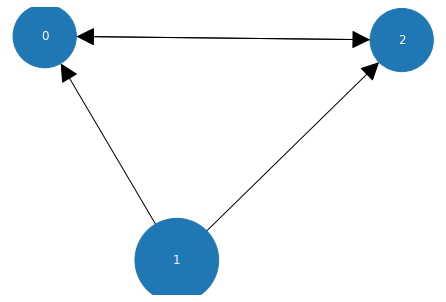

In [27]:
# size based on links
internet.plot1()

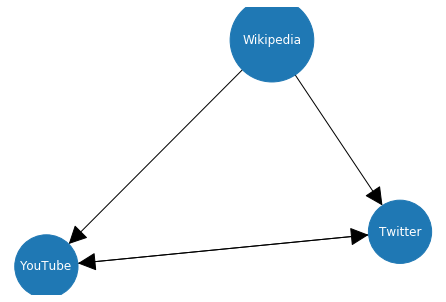

In [28]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

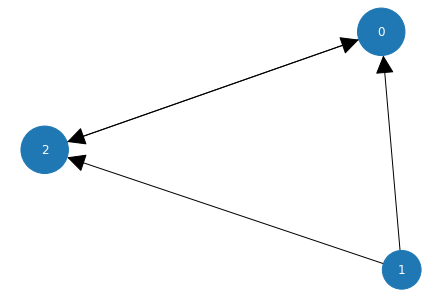

In [29]:
#size based on rank
internet.plot2()

### With graphviz

In [30]:
#internet.plot0()

### Example Calculation with Homepage to 99 Sites

#### Certain Restart Version

In [31]:
internetV2= Network()
homepage = Page("Homepage")
for i in range(0,99):
    p = Page("test" + str(i))
    homepage.addLinkTo(p)
    internetV2.addPage(p)
internetV2.addPage(homepage)
PageRanker.rankCR(internetV2, 100, 0.5)
internetV2.showRanking()
internetV2.debugRanking()

test0: 0.010000502537815986
test1: 0.010000502537815986
test2: 0.010000502537815986
test3: 0.010000502537815986
test4: 0.010000502537815986
test5: 0.010000502537815986
test6: 0.010000502537815986
test7: 0.010000502537815986
test8: 0.010000502537815986
test9: 0.010000502537815986
test10: 0.010000502537815986
test11: 0.010000502537815986
test12: 0.010000502537815986
test13: 0.010000502537815986
test14: 0.010000502537815986
test15: 0.010000502537815986
test16: 0.010000502537815986
test17: 0.010000502537815986
test18: 0.010000502537815986
test19: 0.010000502537815986
test20: 0.010000502537815986
test21: 0.010000502537815986
test22: 0.010000502537815986
test23: 0.010000502537815986
test24: 0.010000502537815986
test25: 0.010000502537815986
test26: 0.010000502537815986
test27: 0.010000502537815986
test28: 0.010000502537815986
test29: 0.010000502537815986
test30: 0.010000502537815986
test31: 0.010000502537815986
test32: 0.010000502537815986
test33: 0.010000502537815986
test34: 0.01000050253781

#### Normalizer Version

In [32]:
PageRanker.rank(internetV2, 100, 0.5)
internetV2.showRanking()
internetV2.debugRanking()

test0: 0.010000502537815956
test1: 0.010000502537815956
test2: 0.010000502537815956
test3: 0.010000502537815956
test4: 0.010000502537815956
test5: 0.010000502537815956
test6: 0.010000502537815956
test7: 0.010000502537815956
test8: 0.010000502537815956
test9: 0.010000502537815956
test10: 0.010000502537815956
test11: 0.010000502537815956
test12: 0.010000502537815956
test13: 0.010000502537815956
test14: 0.010000502537815956
test15: 0.010000502537815956
test16: 0.010000502537815956
test17: 0.010000502537815956
test18: 0.010000502537815956
test19: 0.010000502537815956
test20: 0.010000502537815956
test21: 0.010000502537815956
test22: 0.010000502537815956
test23: 0.010000502537815956
test24: 0.010000502537815956
test25: 0.010000502537815956
test26: 0.010000502537815956
test27: 0.010000502537815956
test28: 0.010000502537815956
test29: 0.010000502537815956
test30: 0.010000502537815956
test31: 0.010000502537815956
test32: 0.010000502537815956
test33: 0.010000502537815956
test34: 0.01000050253781

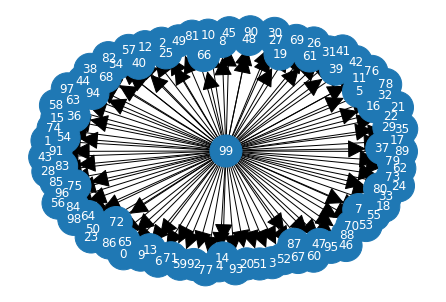

In [33]:
internetV2.plot2()

### Example Calculation with "Endpage" which is linked to from 99 Sites

#### Certain Restart Version

In [34]:
internetV3= Network()
endpage = Page("Endpage")
for i in range(0,99):
    p = Page("test" + str(i))
    p.addLinkTo(endpage)
    internetV3.addPage(p)
internetV3.addPage(endpage)
PageRanker.rankCR(internetV3, 1000, 0.5)
internetV3.showRanking()
internetV3.debugRanking()

test0: 0.006688963210702344
test1: 0.006688963210702344
test2: 0.006688963210702344
test3: 0.006688963210702344
test4: 0.006688963210702344
test5: 0.006688963210702344
test6: 0.006688963210702344
test7: 0.006688963210702344
test8: 0.006688963210702344
test9: 0.006688963210702344
test10: 0.006688963210702344
test11: 0.006688963210702344
test12: 0.006688963210702344
test13: 0.006688963210702344
test14: 0.006688963210702344
test15: 0.006688963210702344
test16: 0.006688963210702344
test17: 0.006688963210702344
test18: 0.006688963210702344
test19: 0.006688963210702344
test20: 0.006688963210702344
test21: 0.006688963210702344
test22: 0.006688963210702344
test23: 0.006688963210702344
test24: 0.006688963210702344
test25: 0.006688963210702344
test26: 0.006688963210702344
test27: 0.006688963210702344
test28: 0.006688963210702344
test29: 0.006688963210702344
test30: 0.006688963210702344
test31: 0.006688963210702344
test32: 0.006688963210702344
test33: 0.006688963210702344
test34: 0.00668896321070

#### Normalizer Version

In [35]:
PageRanker.rank(internetV3, 1000, 0.5)
internetV3.showRanking()
internetV3.debugRanking()

test0: 0.006688963210702337
test1: 0.006688963210702337
test2: 0.006688963210702337
test3: 0.006688963210702337
test4: 0.006688963210702337
test5: 0.006688963210702337
test6: 0.006688963210702337
test7: 0.006688963210702337
test8: 0.006688963210702337
test9: 0.006688963210702337
test10: 0.006688963210702337
test11: 0.006688963210702337
test12: 0.006688963210702337
test13: 0.006688963210702337
test14: 0.006688963210702337
test15: 0.006688963210702337
test16: 0.006688963210702337
test17: 0.006688963210702337
test18: 0.006688963210702337
test19: 0.006688963210702337
test20: 0.006688963210702337
test21: 0.006688963210702337
test22: 0.006688963210702337
test23: 0.006688963210702337
test24: 0.006688963210702337
test25: 0.006688963210702337
test26: 0.006688963210702337
test27: 0.006688963210702337
test28: 0.006688963210702337
test29: 0.006688963210702337
test30: 0.006688963210702337
test31: 0.006688963210702337
test32: 0.006688963210702337
test33: 0.006688963210702337
test34: 0.00668896321070

## Statistics

In [36]:
internet.sources()

,Name,Outdegree,Indegree
1,Wikipedia,2,0


In [37]:
internet.sinks()

,Name,Outdegree,Indegree


In [38]:
california.sinks()

,Name,Outdegree,Indegree
9,http://www.leginfo.ca.gov/calaw.html,0,155
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
15,http://www.csupomona.edu/,0,36
16,http://www.csuchico.edu/,0,32
33,http://www.ftb.ca.gov/,0,46
...,...,...,...
9655,http://www.fleamarket.net/,0,0
9658,http://remco.com/fun.html,0,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0


In [39]:
california.sources()

,Name,Outdegree,Indegree
7,http://www.tegnetcorporation.com/,11,0
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
79,http://www.mapquest.com/wine/mqinterconnect,1,0
95,http://www.angelfire.com/ca/srcom/index.html,4,0
120,http://www.psn.net/support/access_num.phtml,2,0
...,...,...,...
9659,http://www.spd.louisville.edu/~mejenn01/handy....,1,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0
9662,http://www.meats.net/,0,0


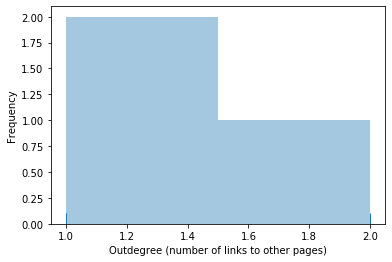

In [133]:
internet.plot_outdegrees()

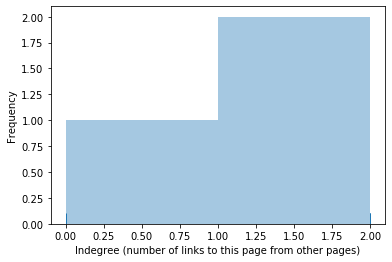

In [41]:
internet.plot_indegrees()

In [42]:
internet.describe()

,Outdegree,Indegree
count,3.000000,3.000000
mean,1.333333,1.333333
std,0.577350,1.154701
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.500000,2.000000
max,2.000000,2.000000


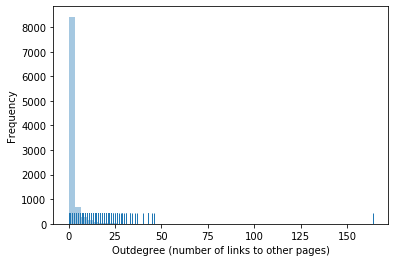

In [43]:
california.plot_outdegrees()

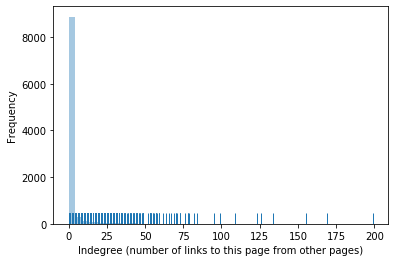

In [44]:
california.plot_indegrees()

In [45]:
california.describe()

,Outdegree,Indegree
count,9664.000000,9664.000000
mean,1.671151,1.671151
std,3.695696,7.457138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,164.000000,199.000000


# Example networks

## 10 websites

### Twee of drie verschillende stelsels, Customization: Add third little network of 2 websites and/or add a link from website 8 to these two websites

In [46]:
#hier kunnen zo'n hashtags voor worden gezet voor verschillende stelsels/links

Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")

Website1.addLinkTo(Website2)
Website1.addLinkTo(Website3)
Website1.addLinkTo(Website4)

Website2.addLinkTo(Website1)
Website2.addLinkTo(Website3)
Website2.addLinkTo(Website4)

Website3.addLinkTo(Website1)
Website3.addLinkTo(Website2)
Website3.addLinkTo(Website4)

Website4.addLinkTo(Website1)
Website4.addLinkTo(Website2)
Website4.addLinkTo(Website3)

Website5.addLinkTo(Website6)
Website5.addLinkTo(Website7)
Website5.addLinkTo(Website8)

Website6.addLinkTo(Website5)
Website6.addLinkTo(Website7)
Website6.addLinkTo(Website8)

Website7.addLinkTo(Website5)
Website7.addLinkTo(Website6)
Website7.addLinkTo(Website8)

Website8.addLinkTo(Website5)
Website8.addLinkTo(Website6)
Website8.addLinkTo(Website7)

#Website8.addLinkTo(Website9)
#Website8.addLinkTo(Website10)

#Website9.addLinkTo(Website10)
#Website10.addLinkTo(Website9)


network2Different = Network()
network2Different.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8)
#network2Different.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [47]:
PageRanker.rankCR(network2Different, 10, 0.5)
network2Different.showRanking()
network2Different.debugRanking()

Website1: 0.12499999999999999
Website2: 0.12499999999999999
Website3: 0.12499999999999999
Website4: 0.12499999999999999
Website5: 0.12499999999999999
Website6: 0.12499999999999999
Website7: 0.12499999999999999
Website8: 0.12499999999999999
0.9999999999999999


In [48]:
PageRanker.rank(network2Different, 10, 0.5)
network2Different.showRanking()

Website1: 0.125
Website2: 0.125
Website3: 0.125
Website4: 0.125
Website5: 0.125
Website6: 0.125
Website7: 0.125
Website8: 0.125


In [49]:
network2Different.debugRanking()

1.0


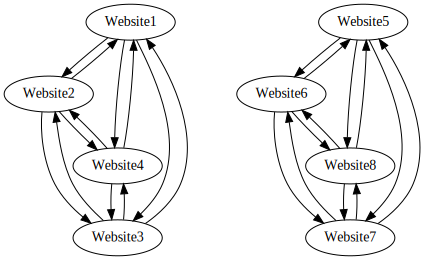

In [50]:
network2Different.plot0()

### Everything to website 1, Customization: add links from website 1 to all pages

In [51]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")

#Website1.addLinkTo(Website2)
#Website1.addLinkTo(Website3)
#Website1.addLinkTo(Website4)
#Website1.addLinkTo(Website5)
#Website1.addLinkTo(Website6)
#Website1.addLinkTo(Website7)
#Website1.addLinkTo(Website8)
#Website1.addLinkTo(Website9)
#Website1.addLinkTo(Website10)


Website2.addLinkTo(Website1)
Website3.addLinkTo(Website1)
Website4.addLinkTo(Website1)
Website5.addLinkTo(Website1)
Website6.addLinkTo(Website1)
Website7.addLinkTo(Website1)
Website8.addLinkTo(Website1)
Website9.addLinkTo(Website1)
Website10.addLinkTo(Website1)


networkAllToOne = Network()
networkAllToOne.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [52]:
PageRanker.rankCR(networkAllToOne, 10, 0.5)
networkAllToOne.showRanking()
networkAllToOne.debugRanking()

Website1: 0.3792152378985449
Website2: 0.06897608467793949
Website3: 0.06897608467793949
Website4: 0.06897608467793949
Website5: 0.06897608467793949
Website6: 0.06897608467793949
Website7: 0.06897608467793949
Website8: 0.06897608467793949
Website9: 0.06897608467793949
Website10: 0.06897608467793949
1.0000000000000002


In [53]:
PageRanker.rank(networkAllToOne, 10, 0.5)
networkAllToOne.showRanking()
networkAllToOne.debugRanking()

Website1: 0.37931034482758613
Website2: 0.06896551724137931
Website3: 0.06896551724137931
Website4: 0.06896551724137931
Website5: 0.06896551724137931
Website6: 0.06896551724137931
Website7: 0.06896551724137931
Website8: 0.06896551724137931
Website9: 0.06896551724137931
Website10: 0.06896551724137931
1.0


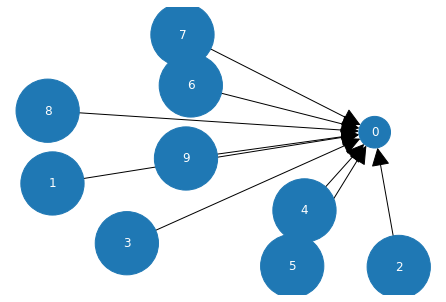

In [54]:
networkAllToOne.plot1()

### All websites go to eachother except website 10

In [55]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")

Website1.addLinkTo(Website2)
Website1.addLinkTo(Website3)
Website1.addLinkTo(Website4)
Website1.addLinkTo(Website5)
Website1.addLinkTo(Website6)
Website1.addLinkTo(Website7)
Website1.addLinkTo(Website8)
Website1.addLinkTo(Website9)
Website1.addLinkTo(Website10)

Website2.addLinkTo(Website1)
Website2.addLinkTo(Website3)
Website2.addLinkTo(Website4)
Website2.addLinkTo(Website5)
Website2.addLinkTo(Website6)
Website2.addLinkTo(Website7)
Website2.addLinkTo(Website8)
Website2.addLinkTo(Website9)
Website2.addLinkTo(Website10)

Website3.addLinkTo(Website1)
Website3.addLinkTo(Website2)
Website3.addLinkTo(Website4)
Website3.addLinkTo(Website5)
Website3.addLinkTo(Website6)
Website3.addLinkTo(Website7)
Website3.addLinkTo(Website8)
Website3.addLinkTo(Website9)
Website3.addLinkTo(Website10)

Website4.addLinkTo(Website1)
Website4.addLinkTo(Website2)
Website4.addLinkTo(Website3)
Website4.addLinkTo(Website5)
Website4.addLinkTo(Website6)
Website4.addLinkTo(Website7)
Website4.addLinkTo(Website8)
Website4.addLinkTo(Website9)
Website4.addLinkTo(Website10)

Website5.addLinkTo(Website1)
Website5.addLinkTo(Website2)
Website5.addLinkTo(Website3)
Website5.addLinkTo(Website4)
Website5.addLinkTo(Website6)
Website5.addLinkTo(Website7)
Website5.addLinkTo(Website8)
Website5.addLinkTo(Website9)
Website5.addLinkTo(Website10)

Website6.addLinkTo(Website1)
Website6.addLinkTo(Website2)
Website6.addLinkTo(Website3)
Website6.addLinkTo(Website4)
Website6.addLinkTo(Website5)
Website6.addLinkTo(Website7)
Website6.addLinkTo(Website8)
Website6.addLinkTo(Website9)
Website6.addLinkTo(Website10)

Website7.addLinkTo(Website1)
Website7.addLinkTo(Website2)
Website7.addLinkTo(Website3)
Website7.addLinkTo(Website4)
Website7.addLinkTo(Website5)
Website7.addLinkTo(Website6)
Website7.addLinkTo(Website8)
Website7.addLinkTo(Website9)
Website7.addLinkTo(Website10)

Website8.addLinkTo(Website1)
Website8.addLinkTo(Website2)
Website8.addLinkTo(Website3)
Website8.addLinkTo(Website4)
Website8.addLinkTo(Website5)
Website8.addLinkTo(Website6)
Website8.addLinkTo(Website7)
Website8.addLinkTo(Website9)
Website8.addLinkTo(Website10)

Website9.addLinkTo(Website1)
Website9.addLinkTo(Website2)
Website9.addLinkTo(Website3)
Website9.addLinkTo(Website4)
Website9.addLinkTo(Website5)
Website9.addLinkTo(Website6)
Website9.addLinkTo(Website7)
Website9.addLinkTo(Website8)
Website9.addLinkTo(Website10)

networkAllButOneToAll = Network()
networkAllButOneToAll.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [56]:
PageRanker.rankCR(networkAllButOneToAll, 10, 0.5)
networkAllButOneToAll.showRanking()
networkAllButOneToAll.debugRanking()

Website1: 0.09944751381215473
Website2: 0.09944751381215473
Website3: 0.09944751381215473
Website4: 0.09944751381215473
Website5: 0.09944751381215473
Website6: 0.09944751381215473
Website7: 0.09944751381215473
Website8: 0.09944751381215473
Website9: 0.09944751381215473
Website10: 0.10497237569060777
1.0000000000000004


In [57]:
PageRanker.rank(networkAllButOneToAll, 10, 0.5)
networkAllButOneToAll.showRanking()
networkAllButOneToAll.debugRanking()

Website1: 0.09944749086424848
Website2: 0.09944749086424848
Website3: 0.09944749086424848
Website4: 0.09944749086424848
Website5: 0.09944749086424848
Website6: 0.09944749086424848
Website7: 0.09944749086424848
Website8: 0.09944749086424848
Website9: 0.09944749086424848
Website10: 0.10497258222176362
0.9999999999999999


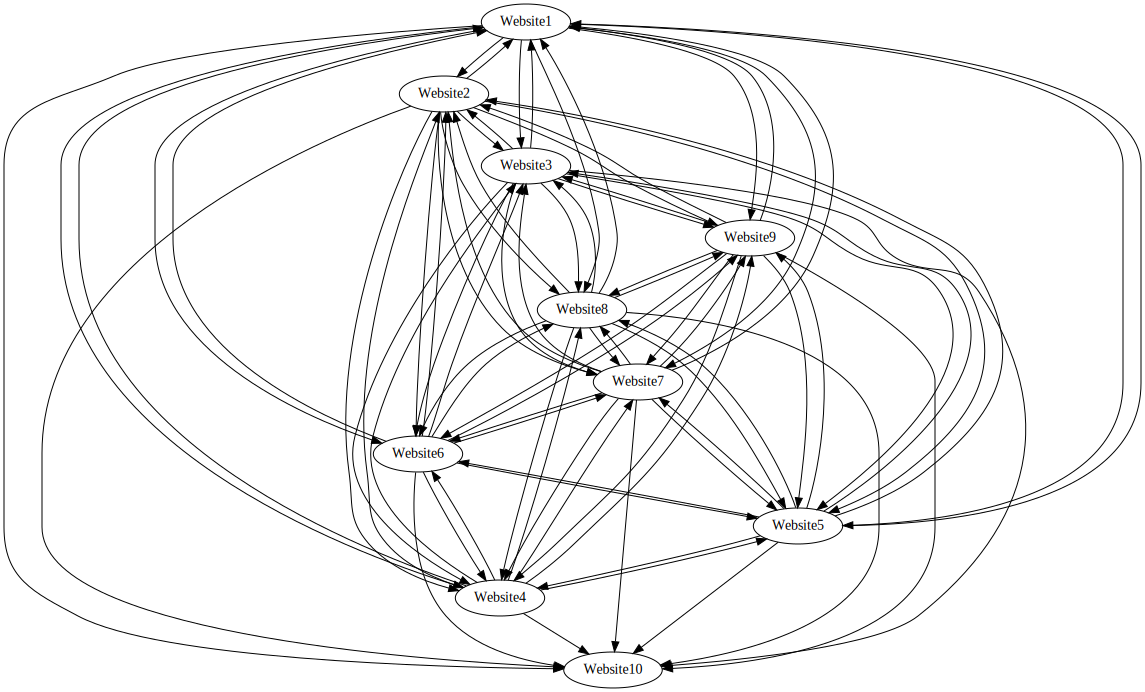

In [58]:
networkAllButOneToAll.plot0()

### Circle network

In [59]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")

Website1.addLinkTo(Website2)
Website2.addLinkTo(Website3)
Website3.addLinkTo(Website4)
Website4.addLinkTo(Website5)
Website5.addLinkTo(Website6)
Website6.addLinkTo(Website7)
Website7.addLinkTo(Website8)
Website8.addLinkTo(Website9)
Website9.addLinkTo(Website10)
Website10.addLinkTo(Website1)

networkCircle = Network()
networkCircle.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [60]:
PageRanker.rankCR(networkCircle, 10, 0.5)
networkCircle.showRanking()
networkCircle.debugRanking()

Website1: 0.10000000000000009
Website2: 0.10000000000000009
Website3: 0.10000000000000009
Website4: 0.10000000000000009
Website5: 0.10000000000000009
Website6: 0.10000000000000009
Website7: 0.10000000000000009
Website8: 0.10000000000000009
Website9: 0.10000000000000009
Website10: 0.10000000000000009
1.0000000000000009


In [61]:
PageRanker.rank(networkCircle, 10, 0.5)
networkCircle.showRanking()
networkCircle.debugRanking()

Website1: 0.10000000000000002
Website2: 0.10000000000000002
Website3: 0.10000000000000002
Website4: 0.10000000000000002
Website5: 0.10000000000000002
Website6: 0.10000000000000002
Website7: 0.10000000000000002
Website8: 0.10000000000000002
Website9: 0.10000000000000002
Website10: 0.10000000000000002
1.0


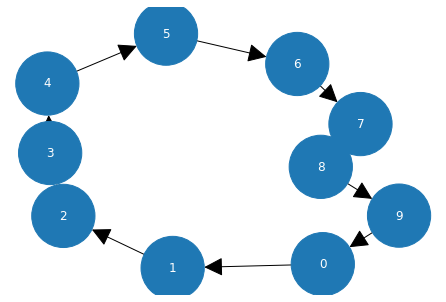

In [62]:
networkCircle.plot1()

### Two clusters with one link

In [63]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")

Website1.addLinkTo(Website2)
Website1.addLinkTo(Website3)
Website1.addLinkTo(Website4)
Website1.addLinkTo(Website5)

Website2.addLinkTo(Website1)
Website2.addLinkTo(Website3)
Website2.addLinkTo(Website4)
Website2.addLinkTo(Website5)

Website3.addLinkTo(Website1)
Website3.addLinkTo(Website2)
Website3.addLinkTo(Website4)
Website3.addLinkTo(Website5)

Website4.addLinkTo(Website1)
Website4.addLinkTo(Website2)
Website4.addLinkTo(Website3)
Website4.addLinkTo(Website5)

Website5.addLinkTo(Website1)
Website5.addLinkTo(Website2)
Website5.addLinkTo(Website3)
Website5.addLinkTo(Website4)
Website5.addLinkTo(Website6)

Website6.addLinkTo(Website5)
Website6.addLinkTo(Website7)
Website6.addLinkTo(Website8)
Website6.addLinkTo(Website9)
Website6.addLinkTo(Website10)

Website7.addLinkTo(Website6)
Website7.addLinkTo(Website8)
Website7.addLinkTo(Website9)
Website7.addLinkTo(Website10)

Website8.addLinkTo(Website6)
Website8.addLinkTo(Website7)
Website8.addLinkTo(Website9)
Website8.addLinkTo(Website10)

Website9.addLinkTo(Website6)
Website9.addLinkTo(Website7)
Website9.addLinkTo(Website8)
Website9.addLinkTo(Website10)

Website10.addLinkTo(Website6)
Website10.addLinkTo(Website7)
Website10.addLinkTo(Website8)
Website10.addLinkTo(Website9)


networkCluster = Network()
networkCluster.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10)

In [64]:
PageRanker.rankCR(networkCluster, 10, 0.5)
networkCluster.showRanking()
networkCluster.debugRanking()

Website1: 0.09756097560975614
Website2: 0.09756097560975614
Website3: 0.09756097560975614
Website4: 0.09756097560975614
Website5: 0.10975609756097565
Website6: 0.10975609756097564
Website7: 0.09756097560975613
Website8: 0.09756097560975613
Website9: 0.09756097560975613
Website10: 0.09756097560975613
1.0000000000000004


In [65]:
PageRanker.rank(networkCluster, 10, 0.5)
networkCluster.showRanking()
networkCluster.debugRanking()

Website1: 0.09756097560975611
Website2: 0.09756097560975611
Website3: 0.09756097560975611
Website4: 0.09756097560975611
Website5: 0.10975609756097564
Website6: 0.10975609756097562
Website7: 0.09756097560975611
Website8: 0.09756097560975611
Website9: 0.09756097560975611
Website10: 0.09756097560975611
1.0


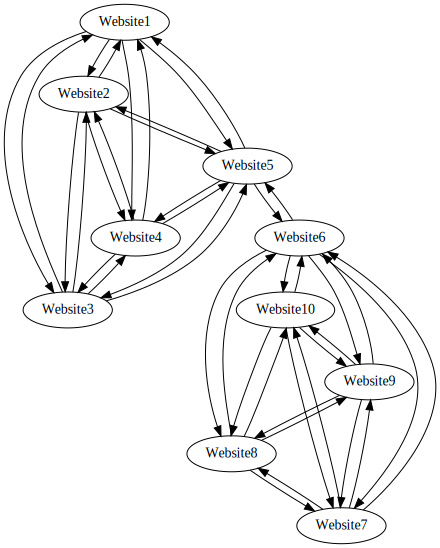

In [66]:
networkCluster.plot0()

## Now the same networks but 100 websites

### All websites link to one website

In [67]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")
Website11 = Page("Website11")
Website12 = Page("Website12")
Website13 = Page("Website13")
Website14 = Page("Website14")
Website15 = Page("Website15")
Website16 = Page("Website16")
Website17 = Page("Website17")
Website18 = Page("Website18")
Website19 = Page("Website19")
Website20 = Page("Website20")
Website21 = Page("Website21")
Website22 = Page("Website22")
Website23 = Page("Website23")
Website24 = Page("Website24")
Website25 = Page("Website25")
Website26 = Page("Website26")
Website27 = Page("Website27")
Website28 = Page("Website28")
Website29 = Page("Website29")
Website30 = Page("Website30")
Website31 = Page("Website31")
Website32 = Page("Website32")
Website33 = Page("Website33")
Website34 = Page("Website34")
Website35 = Page("Website35")
Website36 = Page("Website36")
Website37 = Page("Website37")
Website38 = Page("Website38")
Website39 = Page("Website39")
Website40 = Page("Website40")
Website41 = Page("Website41")
Website42 = Page("Website42")
Website43 = Page("Website43")
Website44 = Page("Website44")
Website45 = Page("Website45")
Website46 = Page("Website46")
Website47 = Page("Website47")
Website48 = Page("Website48")
Website49 = Page("Website49")
Website50 = Page("Website50")
Website51 = Page("Website51")
Website52 = Page("Website52")
Website53 = Page("Website53")
Website54 = Page("Website54")
Website55 = Page("Website55")
Website56 = Page("Website56")
Website57 = Page("Website57")
Website58 = Page("Website58")
Website59 = Page("Website59")
Website60 = Page("Website60")
Website61 = Page("Website61")
Website62 = Page("Website62")
Website63 = Page("Website63")
Website64 = Page("Website64")
Website65 = Page("Website65")
Website66 = Page("Website66")
Website67 = Page("Website67")
Website68 = Page("Website68")
Website69 = Page("Website69")
Website70 = Page("Website70")
Website71 = Page("Website71")
Website72 = Page("Website72")
Website73 = Page("Website73")
Website74 = Page("Website74")
Website75 = Page("Website75")
Website76 = Page("Website76")
Website77 = Page("Website77")
Website78 = Page("Website78")
Website79 = Page("Website79")
Website80 = Page("Website80")
Website81 = Page("Website81")
Website82 = Page("Website82")
Website83 = Page("Website83")
Website84 = Page("Website84")
Website85 = Page("Website85")
Website86 = Page("Website86")
Website87 = Page("Website87")
Website88 = Page("Website88")
Website89 = Page("Website89")
Website90 = Page("Website90")
Website91 = Page("Website91")
Website92 = Page("Website92")
Website93 = Page("Website93")
Website94 = Page("Website94")
Website95 = Page("Website95")
Website96 = Page("Website96")
Website97 = Page("Website97")
Website98 = Page("Website98")
Website99 = Page("Website99")
Website100 = Page("Website100")

WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
               Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
               Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
               Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
               Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
               Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
               Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
               Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
               Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
               Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]
               
i=1
while i<100:
    Website1.addLinkTo(WebsiteList[i])
    WebsiteList[i].addLinkTo(Website1)
    i+=1
    
networkAllToOne100 = Network()
networkAllToOne100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
                           Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
                           Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
                           Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
                           Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
                           Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
                           Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
                           Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
                           Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
                           Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [68]:
PageRanker.rankCR(networkAllToOne100, 100, 0.5)
networkAllToOne100.showRanking()
networkAllToOne100.debugRanking()

Website1: 0.3366666666666646
Website2: 0.006700336700336652
Website3: 0.006700336700336652
Website4: 0.006700336700336652
Website5: 0.006700336700336652
Website6: 0.006700336700336652
Website7: 0.006700336700336652
Website8: 0.006700336700336652
Website9: 0.006700336700336652
Website10: 0.006700336700336652
Website11: 0.006700336700336652
Website12: 0.006700336700336652
Website13: 0.006700336700336652
Website14: 0.006700336700336652
Website15: 0.006700336700336652
Website16: 0.006700336700336652
Website17: 0.006700336700336652
Website18: 0.006700336700336652
Website19: 0.006700336700336652
Website20: 0.006700336700336652
Website21: 0.006700336700336652
Website22: 0.006700336700336652
Website23: 0.006700336700336652
Website24: 0.006700336700336652
Website25: 0.006700336700336652
Website26: 0.006700336700336652
Website27: 0.006700336700336652
Website28: 0.006700336700336652
Website29: 0.006700336700336652
Website30: 0.006700336700336652
Website31: 0.006700336700336652
Website32: 0.006700

In [69]:
PageRanker.rank(networkAllToOne100, 10, 0.5)
networkAllToOne100.showRanking()
networkAllToOne100.debugRanking()

Website1: 0.33634765625000074
Website2: 0.006703559027777785
Website3: 0.006703559027777785
Website4: 0.006703559027777785
Website5: 0.006703559027777785
Website6: 0.006703559027777785
Website7: 0.006703559027777785
Website8: 0.006703559027777785
Website9: 0.006703559027777785
Website10: 0.006703559027777785
Website11: 0.006703559027777785
Website12: 0.006703559027777785
Website13: 0.006703559027777785
Website14: 0.006703559027777785
Website15: 0.006703559027777785
Website16: 0.006703559027777785
Website17: 0.006703559027777785
Website18: 0.006703559027777785
Website19: 0.006703559027777785
Website20: 0.006703559027777785
Website21: 0.006703559027777785
Website22: 0.006703559027777785
Website23: 0.006703559027777785
Website24: 0.006703559027777785
Website25: 0.006703559027777785
Website26: 0.006703559027777785
Website27: 0.006703559027777785
Website28: 0.006703559027777785
Website29: 0.006703559027777785
Website30: 0.006703559027777785
Website31: 0.006703559027777785
Website32: 0.00670

### All websites go to eachother except website 1

In [70]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")
Website11 = Page("Website11")
Website12 = Page("Website12")
Website13 = Page("Website13")
Website14 = Page("Website14")
Website15 = Page("Website15")
Website16 = Page("Website16")
Website17 = Page("Website17")
Website18 = Page("Website18")
Website19 = Page("Website19")
Website20 = Page("Website20")
Website21 = Page("Website21")
Website22 = Page("Website22")
Website23 = Page("Website23")
Website24 = Page("Website24")
Website25 = Page("Website25")
Website26 = Page("Website26")
Website27 = Page("Website27")
Website28 = Page("Website28")
Website29 = Page("Website29")
Website30 = Page("Website30")
Website31 = Page("Website31")
Website32 = Page("Website32")
Website33 = Page("Website33")
Website34 = Page("Website34")
Website35 = Page("Website35")
Website36 = Page("Website36")
Website37 = Page("Website37")
Website38 = Page("Website38")
Website39 = Page("Website39")
Website40 = Page("Website40")
Website41 = Page("Website41")
Website42 = Page("Website42")
Website43 = Page("Website43")
Website44 = Page("Website44")
Website45 = Page("Website45")
Website46 = Page("Website46")
Website47 = Page("Website47")
Website48 = Page("Website48")
Website49 = Page("Website49")
Website50 = Page("Website50")
Website51 = Page("Website51")
Website52 = Page("Website52")
Website53 = Page("Website53")
Website54 = Page("Website54")
Website55 = Page("Website55")
Website56 = Page("Website56")
Website57 = Page("Website57")
Website58 = Page("Website58")
Website59 = Page("Website59")
Website60 = Page("Website60")
Website61 = Page("Website61")
Website62 = Page("Website62")
Website63 = Page("Website63")
Website64 = Page("Website64")
Website65 = Page("Website65")
Website66 = Page("Website66")
Website67 = Page("Website67")
Website68 = Page("Website68")
Website69 = Page("Website69")
Website70 = Page("Website70")
Website71 = Page("Website71")
Website72 = Page("Website72")
Website73 = Page("Website73")
Website74 = Page("Website74")
Website75 = Page("Website75")
Website76 = Page("Website76")
Website77 = Page("Website77")
Website78 = Page("Website78")
Website79 = Page("Website79")
Website80 = Page("Website80")
Website81 = Page("Website81")
Website82 = Page("Website82")
Website83 = Page("Website83")
Website84 = Page("Website84")
Website85 = Page("Website85")
Website86 = Page("Website86")
Website87 = Page("Website87")
Website88 = Page("Website88")
Website89 = Page("Website89")
Website90 = Page("Website90")
Website91 = Page("Website91")
Website92 = Page("Website92")
Website93 = Page("Website93")
Website94 = Page("Website94")
Website95 = Page("Website95")
Website96 = Page("Website96")
Website97 = Page("Website97")
Website98 = Page("Website98")
Website99 = Page("Website99")
Website100 = Page("Website100")

WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
               Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
               Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
               Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
               Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
               Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
               Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
               Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
               Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
               Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]
               
i=1
j=0
while i<100:
    while j<100:
        if i != j:
            WebsiteList[i].addLinkTo(WebsiteList[j])
        j+=1
    j=0
    i+=1
    
networkAllButOneToAll100 = Network()
networkAllButOneToAll100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
                           Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
                           Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
                           Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
                           Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
                           Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
                           Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
                           Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
                           Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
                           Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [71]:
Website1.outgoingLinks

[]

In [72]:
PageRanker.rankCR(networkAllButOneToAll100, 100, 0.5)
networkAllButOneToAll100.showRanking()
networkAllButOneToAll100.debugRanking()

Website1: 0.010049997474875037
Website2: 0.009999494975001293
Website3: 0.009999494975001293
Website4: 0.009999494975001293
Website5: 0.009999494975001293
Website6: 0.009999494975001293
Website7: 0.009999494975001293
Website8: 0.009999494975001293
Website9: 0.009999494975001293
Website10: 0.009999494975001293
Website11: 0.009999494975001293
Website12: 0.009999494975001293
Website13: 0.009999494975001293
Website14: 0.009999494975001293
Website15: 0.009999494975001293
Website16: 0.009999494975001293
Website17: 0.009999494975001293
Website18: 0.009999494975001293
Website19: 0.009999494975001293
Website20: 0.009999494975001293
Website21: 0.009999494975001293
Website22: 0.009999494975001293
Website23: 0.009999494975001293
Website24: 0.009999494975001293
Website25: 0.009999494975001293
Website26: 0.009999494975001293
Website27: 0.009999494975001293
Website28: 0.009999494975001293
Website29: 0.009999494975001293
Website30: 0.009999494975001293
Website31: 0.009999494975001293
Website32: 0.0099

In [73]:
PageRanker.rank(networkAllButOneToAll100, 100, 0.5)
networkAllButOneToAll100.showRanking()
networkAllButOneToAll100.debugRanking()

Website1: 0.01004999747487499
Website2: 0.009999494975001248
Website3: 0.009999494975001248
Website4: 0.009999494975001248
Website5: 0.009999494975001248
Website6: 0.009999494975001248
Website7: 0.009999494975001248
Website8: 0.009999494975001248
Website9: 0.009999494975001248
Website10: 0.009999494975001248
Website11: 0.009999494975001248
Website12: 0.009999494975001248
Website13: 0.009999494975001248
Website14: 0.009999494975001248
Website15: 0.009999494975001248
Website16: 0.009999494975001248
Website17: 0.009999494975001248
Website18: 0.009999494975001248
Website19: 0.009999494975001248
Website20: 0.009999494975001248
Website21: 0.009999494975001248
Website22: 0.009999494975001248
Website23: 0.009999494975001248
Website24: 0.009999494975001248
Website25: 0.009999494975001248
Website26: 0.009999494975001248
Website27: 0.009999494975001248
Website28: 0.009999494975001248
Website29: 0.009999494975001248
Website30: 0.009999494975001248
Website31: 0.009999494975001248
Website32: 0.00999

### Circle

In [74]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")
Website11 = Page("Website11")
Website12 = Page("Website12")
Website13 = Page("Website13")
Website14 = Page("Website14")
Website15 = Page("Website15")
Website16 = Page("Website16")
Website17 = Page("Website17")
Website18 = Page("Website18")
Website19 = Page("Website19")
Website20 = Page("Website20")
Website21 = Page("Website21")
Website22 = Page("Website22")
Website23 = Page("Website23")
Website24 = Page("Website24")
Website25 = Page("Website25")
Website26 = Page("Website26")
Website27 = Page("Website27")
Website28 = Page("Website28")
Website29 = Page("Website29")
Website30 = Page("Website30")
Website31 = Page("Website31")
Website32 = Page("Website32")
Website33 = Page("Website33")
Website34 = Page("Website34")
Website35 = Page("Website35")
Website36 = Page("Website36")
Website37 = Page("Website37")
Website38 = Page("Website38")
Website39 = Page("Website39")
Website40 = Page("Website40")
Website41 = Page("Website41")
Website42 = Page("Website42")
Website43 = Page("Website43")
Website44 = Page("Website44")
Website45 = Page("Website45")
Website46 = Page("Website46")
Website47 = Page("Website47")
Website48 = Page("Website48")
Website49 = Page("Website49")
Website50 = Page("Website50")
Website51 = Page("Website51")
Website52 = Page("Website52")
Website53 = Page("Website53")
Website54 = Page("Website54")
Website55 = Page("Website55")
Website56 = Page("Website56")
Website57 = Page("Website57")
Website58 = Page("Website58")
Website59 = Page("Website59")
Website60 = Page("Website60")
Website61 = Page("Website61")
Website62 = Page("Website62")
Website63 = Page("Website63")
Website64 = Page("Website64")
Website65 = Page("Website65")
Website66 = Page("Website66")
Website67 = Page("Website67")
Website68 = Page("Website68")
Website69 = Page("Website69")
Website70 = Page("Website70")
Website71 = Page("Website71")
Website72 = Page("Website72")
Website73 = Page("Website73")
Website74 = Page("Website74")
Website75 = Page("Website75")
Website76 = Page("Website76")
Website77 = Page("Website77")
Website78 = Page("Website78")
Website79 = Page("Website79")
Website80 = Page("Website80")
Website81 = Page("Website81")
Website82 = Page("Website82")
Website83 = Page("Website83")
Website84 = Page("Website84")
Website85 = Page("Website85")
Website86 = Page("Website86")
Website87 = Page("Website87")
Website88 = Page("Website88")
Website89 = Page("Website89")
Website90 = Page("Website90")
Website91 = Page("Website91")
Website92 = Page("Website92")
Website93 = Page("Website93")
Website94 = Page("Website94")
Website95 = Page("Website95")
Website96 = Page("Website96")
Website97 = Page("Website97")
Website98 = Page("Website98")
Website99 = Page("Website99")
Website100 = Page("Website100")

WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
               Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
               Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
               Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
               Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
               Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
               Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
               Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
               Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
               Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]


i=0
while i<99:
    WebsiteList[i].addLinkTo(WebsiteList[i+1])
    i+=1
Website100.addLinkTo(Website1)


networkCircle100 = Network()
networkCircle100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
                           Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
                           Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
                           Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
                           Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
                           Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
                           Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
                           Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
                           Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
                           Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [75]:
PageRanker.rankCR(networkCircle100, 100, 0.5)
networkCircle100.showRanking()
networkCircle100.debugRanking()

Website1: 0.009999999999999941
Website2: 0.009999999999999941
Website3: 0.009999999999999941
Website4: 0.009999999999999941
Website5: 0.009999999999999941
Website6: 0.009999999999999941
Website7: 0.009999999999999941
Website8: 0.009999999999999941
Website9: 0.009999999999999941
Website10: 0.009999999999999941
Website11: 0.009999999999999941
Website12: 0.009999999999999941
Website13: 0.009999999999999941
Website14: 0.009999999999999941
Website15: 0.009999999999999941
Website16: 0.009999999999999941
Website17: 0.009999999999999941
Website18: 0.009999999999999941
Website19: 0.009999999999999941
Website20: 0.009999999999999941
Website21: 0.009999999999999941
Website22: 0.009999999999999941
Website23: 0.009999999999999941
Website24: 0.009999999999999941
Website25: 0.009999999999999941
Website26: 0.009999999999999941
Website27: 0.009999999999999941
Website28: 0.009999999999999941
Website29: 0.009999999999999941
Website30: 0.009999999999999941
Website31: 0.009999999999999941
Website32: 0.0099

In [76]:
PageRanker.rank(networkCircle100, 100, 0.5)
networkCircle100.showRanking()
networkCircle100.debugRanking()

Website1: 0.009999999999999993
Website2: 0.009999999999999993
Website3: 0.009999999999999993
Website4: 0.009999999999999993
Website5: 0.009999999999999993
Website6: 0.009999999999999993
Website7: 0.009999999999999993
Website8: 0.009999999999999993
Website9: 0.009999999999999993
Website10: 0.009999999999999993
Website11: 0.009999999999999993
Website12: 0.009999999999999993
Website13: 0.009999999999999993
Website14: 0.009999999999999993
Website15: 0.009999999999999993
Website16: 0.009999999999999993
Website17: 0.009999999999999993
Website18: 0.009999999999999993
Website19: 0.009999999999999993
Website20: 0.009999999999999993
Website21: 0.009999999999999993
Website22: 0.009999999999999993
Website23: 0.009999999999999993
Website24: 0.009999999999999993
Website25: 0.009999999999999993
Website26: 0.009999999999999993
Website27: 0.009999999999999993
Website28: 0.009999999999999993
Website29: 0.009999999999999993
Website30: 0.009999999999999993
Website31: 0.009999999999999993
Website32: 0.0099

### Cluster

In [77]:
Website1 = Page("Website1")
Website2 = Page("Website2")
Website3 = Page("Website3")
Website4 = Page("Website4")
Website5 = Page("Website5")
Website6 = Page("Website6")
Website7 = Page("Website7")
Website8 = Page("Website8")
Website9 = Page("Website9")
Website10 = Page("Website10")
Website11 = Page("Website11")
Website12 = Page("Website12")
Website13 = Page("Website13")
Website14 = Page("Website14")
Website15 = Page("Website15")
Website16 = Page("Website16")
Website17 = Page("Website17")
Website18 = Page("Website18")
Website19 = Page("Website19")
Website20 = Page("Website20")
Website21 = Page("Website21")
Website22 = Page("Website22")
Website23 = Page("Website23")
Website24 = Page("Website24")
Website25 = Page("Website25")
Website26 = Page("Website26")
Website27 = Page("Website27")
Website28 = Page("Website28")
Website29 = Page("Website29")
Website30 = Page("Website30")
Website31 = Page("Website31")
Website32 = Page("Website32")
Website33 = Page("Website33")
Website34 = Page("Website34")
Website35 = Page("Website35")
Website36 = Page("Website36")
Website37 = Page("Website37")
Website38 = Page("Website38")
Website39 = Page("Website39")
Website40 = Page("Website40")
Website41 = Page("Website41")
Website42 = Page("Website42")
Website43 = Page("Website43")
Website44 = Page("Website44")
Website45 = Page("Website45")
Website46 = Page("Website46")
Website47 = Page("Website47")
Website48 = Page("Website48")
Website49 = Page("Website49")
Website50 = Page("Website50")
Website51 = Page("Website51")
Website52 = Page("Website52")
Website53 = Page("Website53")
Website54 = Page("Website54")
Website55 = Page("Website55")
Website56 = Page("Website56")
Website57 = Page("Website57")
Website58 = Page("Website58")
Website59 = Page("Website59")
Website60 = Page("Website60")
Website61 = Page("Website61")
Website62 = Page("Website62")
Website63 = Page("Website63")
Website64 = Page("Website64")
Website65 = Page("Website65")
Website66 = Page("Website66")
Website67 = Page("Website67")
Website68 = Page("Website68")
Website69 = Page("Website69")
Website70 = Page("Website70")
Website71 = Page("Website71")
Website72 = Page("Website72")
Website73 = Page("Website73")
Website74 = Page("Website74")
Website75 = Page("Website75")
Website76 = Page("Website76")
Website77 = Page("Website77")
Website78 = Page("Website78")
Website79 = Page("Website79")
Website80 = Page("Website80")
Website81 = Page("Website81")
Website82 = Page("Website82")
Website83 = Page("Website83")
Website84 = Page("Website84")
Website85 = Page("Website85")
Website86 = Page("Website86")
Website87 = Page("Website87")
Website88 = Page("Website88")
Website89 = Page("Website89")
Website90 = Page("Website90")
Website91 = Page("Website91")
Website92 = Page("Website92")
Website93 = Page("Website93")
Website94 = Page("Website94")
Website95 = Page("Website95")
Website96 = Page("Website96")
Website97 = Page("Website97")
Website98 = Page("Website98")
Website99 = Page("Website99")
Website100 = Page("Website100")

WebsiteList = [Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
               Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
               Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
               Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
               Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
               Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
               Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
               Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
               Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
               Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100]


i=0
j=0
while i<50:
    while j<50:
        if i != j:
            WebsiteList[i].addLinkTo(WebsiteList[j])
        j+=1
    j=0
    i+=1
i=50
j=50
while i<100:
    while j<100:
        if i != j:
            WebsiteList[i].addLinkTo(WebsiteList[j])
        j+=1
    j=50
    i+=1
    
Website50.addLinkTo(Website51)
Website51.addLinkTo(Website50)



networkCluster100 = Network()
networkCluster100.addPages(Website1,Website2,Website3,Website4,Website5,Website6,Website7,Website8,Website9,Website10,
                           Website11,Website12,Website13,Website14,Website15,Website16,Website17,Website18,Website19,Website20,
                           Website21,Website22,Website23,Website24,Website25,Website26,Website27,Website28,Website29,Website30,
                           Website31,Website32,Website33,Website34,Website35,Website36,Website37,Website38,Website39,Website40,
                           Website41,Website42,Website43,Website44,Website45,Website46,Website47,Website48,Website49,Website50,
                           Website51,Website52,Website53,Website54,Website55,Website56,Website57,Website58,Website59,Website60,
                           Website61,Website62,Website63,Website64,Website65,Website66,Website67,Website68,Website69,Website70,
                           Website71,Website72,Website73,Website74,Website75,Website76,Website77,Website78,Website79,Website80,
                           Website81,Website82,Website83,Website84,Website85,Website86,Website87,Website88,Website89,Website90,
                           Website91,Website92,Website93,Website94,Website95,Website96,Website97,Website98,Website99,Website100)

In [78]:
PageRanker.rankCR(networkCluster100, 100, 0.5)
networkCluster100.showRanking()
networkCluster100.debugRanking()

Website1: 0.009997959600081475
Website2: 0.009997959600081475
Website3: 0.009997959600081475
Website4: 0.009997959600081475
Website5: 0.009997959600081475
Website6: 0.009997959600081475
Website7: 0.009997959600081475
Website8: 0.009997959600081475
Website9: 0.009997959600081475
Website10: 0.009997959600081475
Website11: 0.009997959600081475
Website12: 0.009997959600081475
Website13: 0.009997959600081475
Website14: 0.009997959600081475
Website15: 0.009997959600081475
Website16: 0.009997959600081475
Website17: 0.009997959600081475
Website18: 0.009997959600081475
Website19: 0.009997959600081475
Website20: 0.009997959600081475
Website21: 0.009997959600081475
Website22: 0.009997959600081475
Website23: 0.009997959600081475
Website24: 0.009997959600081475
Website25: 0.009997959600081475
Website26: 0.009997959600081475
Website27: 0.009997959600081475
Website28: 0.009997959600081475
Website29: 0.009997959600081475
Website30: 0.009997959600081475
Website31: 0.009997959600081475
Website32: 0.0099

In [79]:
PageRanker.rank(networkCluster100, 100, 0.5)
networkCluster100.showRanking()
networkCluster100.debugRanking()

Website1: 0.009997959600081601
Website2: 0.009997959600081601
Website3: 0.009997959600081601
Website4: 0.009997959600081601
Website5: 0.009997959600081601
Website6: 0.009997959600081601
Website7: 0.009997959600081601
Website8: 0.009997959600081601
Website9: 0.009997959600081601
Website10: 0.009997959600081601
Website11: 0.009997959600081601
Website12: 0.009997959600081601
Website13: 0.009997959600081601
Website14: 0.009997959600081601
Website15: 0.009997959600081601
Website16: 0.009997959600081601
Website17: 0.009997959600081601
Website18: 0.009997959600081601
Website19: 0.009997959600081601
Website20: 0.009997959600081601
Website21: 0.009997959600081601
Website22: 0.009997959600081601
Website23: 0.009997959600081601
Website24: 0.009997959600081601
Website25: 0.009997959600081601
Website26: 0.009997959600081601
Website27: 0.009997959600081601
Website28: 0.009997959600081601
Website29: 0.009997959600081601
Website30: 0.009997959600081601
Website31: 0.009997959600081601
Website32: 0.0099

# The Random "Spatial" Network

This random network of websites is supposed to reflect the spatial nature of the internet. For example, Chinese websites will probably have a lot of links to other Chinese websites and similarly for for example Spanish websites. However, between the two subnetworks (or clusters), there will probably be a lot fewer links. This example network is supposed to reflect that.

In [80]:
spatialNetwork= Network()
df_coords = pd.DataFrame(columns = ["x", "y"])
for i in range(0,100):
    # Determine random integer coordinates between 0 and 100 for all sites
    x = round(10 * random.random())
    y = round(10 * random.random())
    df_coords.loc[i] = [x, y]
    # Keep this information in the "name" string of the website. 
    # Add the filler character "f" such that the coordinates fill up 3 characters

    p = Page("{}".format(x).rjust(3, "f") + "_" + "{}".format(y).rjust(3, "f"))
    spatialNetwork.addPage(p)
    #print("Adding site " + "%03d"%x + "_" + "%03d"%y)
    
    for other in spatialNetwork:
        # Take slices of the other's name and strip zeros accordingly to het back the coordinates
        otherName = other.getName()
        otherX = otherName[:3].lstrip("f")
        otherY = otherName[4:].lstrip("f")
        
        # If the other site and site p are within 5 units of each other (Euclidean distance) (and other =/= p !!)
        distance = (int(otherX)-x)*(int(otherX)-x) + (int(otherY)-y)*(int(otherY)-y)
        if (distance <= 25)&(0<distance):
            other.addLinkTo(p)
            p.addLinkTo(other)

In [87]:
# PageRanker.rankCR(spatialNetwork, 1000, 0.5)
# spatialNetwork.showRanking()
# spatialNetwork.debugRanking()

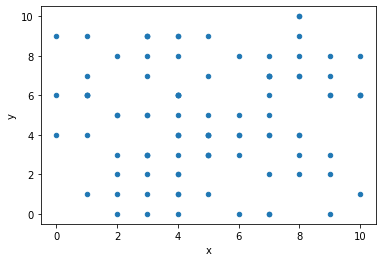

In [88]:
df_coords.plot(kind="scatter", x="x", y="y");

In [89]:
# spatialNetwork.plot2()

In [90]:
spatialNetwork.testUnconnected()

All unreported pages are connected to at least one other node via an incoming/outgoing link.


In [91]:
PageRanker.rank(spatialNetwork)

11

## Completely Random Network

In [92]:
def makeRandomNetwork(n: int = 100, successProbability: float = 0.1):
    randomNetwork= Network()

    for i in range(0,100):
        p = Page("Page {}".format(i))
        randomNetwork.addPage(p)

    for p in randomNetwork:
        for other in randomNetwork:
            # Check if equal
            if not(other.getName() == p.getName()):
                if (random.random() < successProbability):
                    other.addLinkTo(p)
                    
    return randomNetwork

In [96]:
randomNetwork = makeRandomNetwork()

In [97]:
PageRanker.rankCR(randomNetwork, 100, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.010633850193749909
Page 1: 0.009610874342414293
Page 2: 0.011575227189862142
Page 3: 0.00879240930942348
Page 4: 0.009483393673741469
Page 5: 0.01047950855019387
Page 6: 0.010095444794529692
Page 7: 0.007304496308639192
Page 8: 0.010477265991524296
Page 9: 0.00789417911978027
Page 10: 0.008617218697505473
Page 11: 0.010857110532835494
Page 12: 0.008602211617344093
Page 13: 0.010884999541080758
Page 14: 0.011719654739932047
Page 15: 0.009497815723600223
Page 16: 0.008147779631454024
Page 17: 0.008957309214254508
Page 18: 0.009501558027793806
Page 19: 0.007026930788456735
Page 20: 0.008339624101608182
Page 21: 0.013936789305989714
Page 22: 0.00866215072959696
Page 23: 0.013816046820128143
Page 24: 0.013432684138522149
Page 25: 0.011449207790448694
Page 26: 0.009881050058231717
Page 27: 0.010615509487608076
Page 28: 0.007477035172118438
Page 29: 0.011721815124332687
Page 30: 0.00962487564926172
Page 31: 0.010902788328140683
Page 32: 0.010408766344322194
Page 33: 0.00820874666733

In [98]:
PageRanker.rank(randomNetwork, 1000, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.010633850193749886
Page 1: 0.009610874342414274
Page 2: 0.011575227189862118
Page 3: 0.008792409309423464
Page 4: 0.00948339367374145
Page 5: 0.010479508550193849
Page 6: 0.010095444794529672
Page 7: 0.007304496308639178
Page 8: 0.010477265991524277
Page 9: 0.007894179119780255
Page 10: 0.008617218697505457
Page 11: 0.010857110532835472
Page 12: 0.008602211617344075
Page 13: 0.010884999541080739
Page 14: 0.011719654739932027
Page 15: 0.009497815723600206
Page 16: 0.008147779631454008
Page 17: 0.008957309214254491
Page 18: 0.009501558027793787
Page 19: 0.0070269307884567225
Page 20: 0.008339624101608167
Page 21: 0.013936789305989683
Page 22: 0.008662150729596944
Page 23: 0.013816046820128113
Page 24: 0.013432684138522121
Page 25: 0.01144920779044867
Page 26: 0.009881050058231698
Page 27: 0.010615509487608053
Page 28: 0.007477035172118424
Page 29: 0.011721815124332662
Page 30: 0.0096248756492617
Page 31: 0.010902788328140659
Page 32: 0.010408766344322173
Page 33: 0.008208746667

In [99]:
# randomNetwork.plot2()
# randomNetwork.testUnconnected()

In [100]:
PageRanker.rank(randomNetwork)

10

In [101]:
iterations = {}
# n = 1000
n=1
nNodes = 100
for i in range(n):
    p = i/n
    net = makeRandomNetwork(nNodes, p)
    iterations[p] = PageRanker.rank(net)

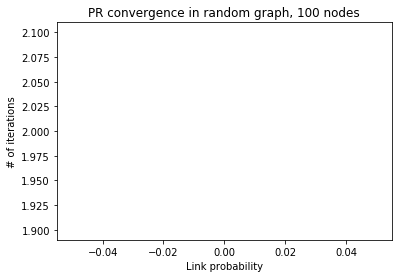

In [102]:
from scipy.ndimage.filters import gaussian_filter1d
x = list(iterations.keys())
y = list(iterations.values())

fig, ax = plt.subplots(1, 1)
# ax.plot(x, y)
ax.plot(x, gaussian_filter1d(y, sigma=2))
ax.set_xlabel("Link probability")
ax.set_ylabel("# of iterations")
ax.set_title(f'PR convergence in random graph, {nNodes} nodes');

In [103]:
# ax.get_figure().savefig("plot.pdf")

## 2WB20 Canvas Page

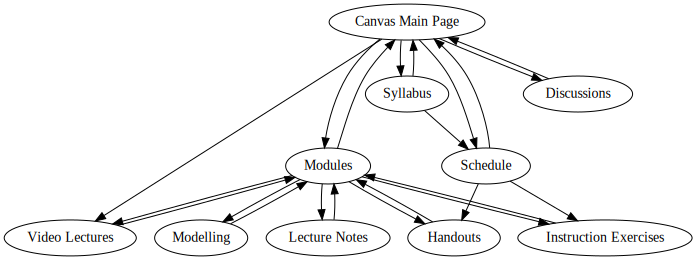

In [104]:
canvas = Network()
w1 = Page("Canvas Main Page")
w2 = Page("Modules")
w3 = Page("Schedule")
w4 = Page("Syllabus")
w5 = Page("Discussions")
w6 = Page("Video Lectures")
w7 = Page("Lecture Notes")
w8 = Page("Instruction Exercises")
w9 = Page("Modelling")
w10 = Page("Handouts")

w1.addLinksTo(w2, w3, w4, w5, w6)
w2.addLinksTo(w1, w6, w7, w8, w9, w10)
w3.addLinksTo(w1, w8, w10)
w4.addLinksTo(w1, w3)
w5.addLinkTo(w1)
w6.addLinkTo(w2)
w7.addLinkTo(w2)
w8.addLinkTo(w2)
w9.addLinkTo(w2)
w10.addLinkTo(w2)

canvas.addPages(w1, w2, w3, w4, w5, w6, w7, w8, w9, w10)
canvas.plot0()

In [122]:
PageRanker.rank(canvas)
canvas.showRanking()

Canvas Main Page: 0.13251670385550707
Modules: 0.26280623584636176
Schedule: 0.07906458796639339
Syllabus: 0.06325167036356727
Discussions: 0.06325167036356727
Video Lectures: 0.08515219007922678
Lecture Notes: 0.07190051971565951
Instruction Exercises: 0.08507795104702875
Modelling: 0.07190051971565951
Handouts: 0.08507795104702875


In [126]:
personalization = [0.7, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9]

In [131]:
PageRanker.rank(canvas, qis=personalization)
canvas.showRanking()

Canvas Main Page: 0.4203167533663985
Modules: 0.16877010611412083
Schedule: 0.07337292748450815
Syllabus: 0.058698341975553556
Discussions: 0.058698341975553556
Video Lectures: 0.07276251756307878
Lecture Notes: 0.030730842254191898
Instruction Exercises: 0.042959663506201395
Modelling: 0.030730842254191898
Handouts: 0.042959663506201395
